# Experiment 1

In this experiment, we try to optimize the parameter of a simple exponential smoothing system with pytorch.

## Setup 

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 5)
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

from utils import *

from trading_strategies import *
test_RS_Trading_Strategy()

In [4]:
prices_dict = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()))

j: 131  -  XASE/BHV


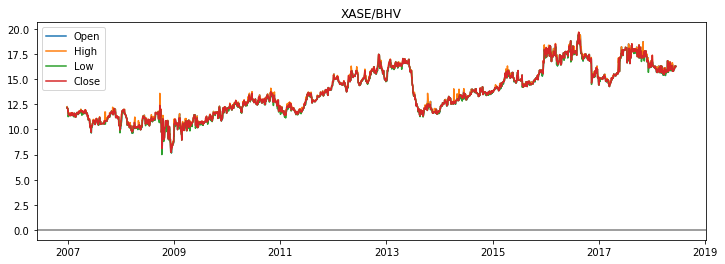

In [5]:
j = np.random.choice(len(prices_dict) - 1)
ticker_j = list(prices_dict.keys())[j]
print('j:', j, ' - ', ticker_j)
# prices_dict[ticker_j][['Open', 'High', 'Low', 'Close']].plot()
plot_prices(prices_dict[ticker_j], name=ticker_j)

## Pytorch

In [7]:
import torch

In [ ]:
class ES1_Trading_Strategy(Trading_Strategy):
    """
    Implements a simple exponential smoothing trading system.
    """
    
    def init_state(self, a=0.1):
        """
        Parameters
        ----------
        a: exponential smoothing constant between 0 and 1. S_t = a * P_t + (1 - a) * S_t-1
        """

        self.state = {'esa': numpy.zeros(len(self.dates)) * numpy.nan,
                      'Trend': numpy.zeros(len(self.dates)) * numpy.nan}
        
        self.a = min(max(a, 0), 1)
        
    
    
    def update_state(self, today_i):
        """
        Updates the Resistance, Support, and Trend variables.
        """
        if today_i == 1:
            self.state['esa'][0] = self.prices['Close'][0]
            self.state['Trend'][0] = 0
        else:        
            self.state['esa'][today_i - 1] = self.a * self.prices['Close'][today_i - 1] + \
                (1 - self.a) * self.state['esa'][today_i - 2]
            self.state['Trend'][today_i - 1] = numpy.sign(self.prices['Close'][today_i - 1] - self.state['esa'][today_i - 1])
    
    
    def entry_order_prices(self, today_i):
        """
        Computes the entry orders for the day (today).
        """
        prev_day_position = self.equity['Position'][today_i - 1]
        state = {k: self.state[k][today_i - 1] for k in self.state.keys()}
        
        if prev_day_position == 0:
            if state['Trend'] == 1:
                self.orders['buy_stop'][today_i] = self.prices['High'][today_i - 1]
            elif state['Trend'] == -1:
                self.orders['sell_stop'][today_i] = self.prices['Low'][today_i - 1]
            else:
                pass
        else:
            pass
    
    
    
    def protective_order_prices(self, today_i):
        """
        Computes the protective orders for the day (today) according to a Support and Resistance system.
        """
        state = {k: self.state[k][today_i - 1] for k in self.state.keys()}
        prev_day_position = self.equity['Position'][today_i - 1]
        
        if self.orders['buy_stop'][today_i] > 0 or prev_day_position > 0:
            self.orders['protective_sell'][today_i] = state['esa']
            
        elif self.orders['sell_stop'][today_i] > 0 or prev_day_position < 0:
            self.orders['protective_buy'][today_i] = state['esa']
            
        else:
            pass